# ToMATo for protein conformation

In [12]:
import numpy as np
from matplotlib import pyplot as plt
import re
from sklearn import manifold
from tqdm import tqdm

## 1- Data loading and visualisation

### Data loading and conversion to usable format

In [1]:
xyz = open("..data/aladip/aladip_implicit.xyz", "r")
k=0
for line in xyz:
    if k<10:
        print('>>> ', line)
        k+=1
    else:
        break
xyz.close()

>>>  24.949 24.689 25.193

>>>  24.881 24.824 25.159

>>>  24.769 24.855 25.208

>>>  24.959 24.901 25.083

>>>  24.917 25.034 25.028

>>>  24.919 25.132 25.141

>>>  24.991 25.083 24.904

>>>  24.974 25.201 24.867

>>>  25.077 24.998 24.830

>>>  25.143 25.022 24.700



In [2]:
xyz = open("..data/aladip/dihedral.xyz", "r")
k=0
for line in xyz:
    if k<10:
        print('>>> ', line)
        k+=1
    else:
        break
xyz.close()

>>>    -2.7394562e+00   1.9710530e-01

>>>    -1.4092216e+00  -3.7683849e-02

>>>    -1.0991716e+00   1.5843425e-01

>>>    -2.6436599e+00  -6.8284164e-02

>>>    -1.2765906e+00  -2.6540122e-01

>>>    -2.2302756e+00   1.7024640e-02

>>>    -2.5553681e+00   2.2676463e-01

>>>    -1.7089955e+00  -7.4869730e-02

>>>    -1.9782164e+00  -1.7803117e-01

>>>    -1.4665155e+00  -2.8951271e-01



In [2]:
def read_xyz(filename, n_rows, n_columns):
    """
    Get coordinates from filename and return a vectorset with all the
    coordinates, in XYZ format.
    Parameters
    ----------
    filename : string
        Filename to read
    Returns
    -------
    atoms : list
        List of atomic types
    V : array
        (N,3) where N is number of atoms
    """

    f = open(filename, 'r')
    V = list()

    # Use the number of rows to not read beyond the end of a file
    for lines_read, line in enumerate(f):

        if lines_read == n_rows:
            break

        numbers = re.findall(r'[-]?\d+\.\d*(?:[Ee][-\+]\d+)?', line)
        numbers = [float(number) for number in numbers]

        if len(numbers) == n_columns:
            V.append(np.array(numbers))
        else:
            exit("Reading the .xyz file failed in line {0}. Please check the format.".format(lines_read + 2))

    f.close()
    V = np.array(V)
    return V

In [4]:
aladip_implicit = read_xyz("../data/aladip/aladip_implicit.xyz", 14207380, 3)

In [11]:
dihedral = read_xyz("..data/aladip/dihedral.xyz", 14207380, 2)

### Visualisation

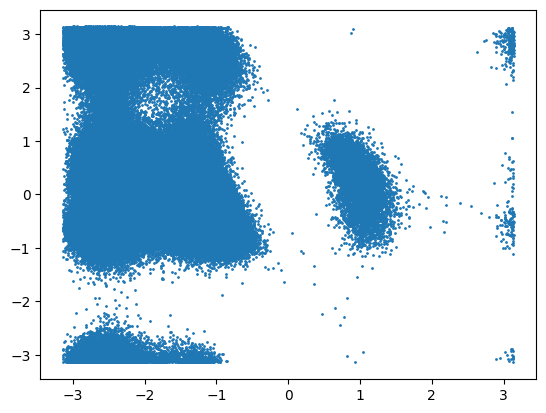

In [12]:
plt.scatter(dihedral[:,0], dihedral[:,1], s=1)
plt.show()

## 2- Compute RMSD distance matrix

### Helper functions

In [14]:
def quaternion_rotate(X, Y):
    """
    Calculate the rotation
    Parameters
    ----------
    X : array
        (N,D) matrix, where N is the number of points and D is dimension.
    Y: array
        (N,D) matrix, where N is the number of points and D is dimension.
    Returns
    -------
    rot : matrix
        Rotation matrix (D,D)
    """
    N = X.shape[0]
    W = np.asarray([makeW(*Y[k]) for k in range(N)])
    Q = np.asarray([makeQ(*X[k]) for k in range(N)])
    Qt_dot_W = np.asarray([np.dot(Q[k].T, W[k]) for k in range(N)])
    W_minus_Q = np.asarray([W[k] - Q[k] for k in range(N)])
    A = np.sum(Qt_dot_W, axis=0)
    eigen = np.linalg.eigh(A)
    r = eigen[1][:, eigen[0].argmax()]
    rot = quaternion_transform(r)
    return rot

def quaternion_transform(r):
    """
    Get optimal rotation
    note: translation will be zero when the centroids of each molecule are the
    same
    """
    Wt_r = makeW(*r).T
    Q_r = makeQ(*r)
    rot = Wt_r.dot(Q_r)[:3, :3]
    return rot


def makeW(r1, r2, r3, r4=0):
    """
    matrix involved in quaternion rotation
    """
    W = np.asarray([
             [r4, r3, -r2, r1],
             [-r3, r4, r1, r2],
             [r2, -r1, r4, r3],
             [-r1, -r2, -r3, r4]])
    return W


def makeQ(r1, r2, r3, r4=0):
    """
    matrix involved in quaternion rotation
    """
    Q = np.asarray([
             [r4, -r3, r2, r1],
             [r3, r4, -r1, r2],
             [-r2, r1, r4, r3],
             [-r1, -r2, -r3, r4]])
    return Q

def centroid(X):
    """
    Calculate the centroid from a vectorset X.
    https://en.wikipedia.org/wiki/Centroid
    Centroid is the mean position of all the points in all of the coordinate
    directions.
    C = sum(X)/len(X)
    Parameters
    ----------
    X : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    C : float
        centeroid
    """
    C = X.mean(axis=0)
    return C

def quaternion_rmsd(P, Q):
    """
    Rotate matrix P unto Q and calculate the RMSD
    based on doi:10.1016/1049-9660(91)90036-O
    Parameters
    ----------
    P : array
        (N,D) matrix, where N is points and D is dimension.
    P : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    rmsd : float
    """
    rot = quaternion_rotate(P, Q)
    P = np.dot(P, rot)
    return rmsd(P, Q)

def rmsd(V, W):
    """
    Calculate Root-mean-square deviation from two sets of vectors V and W.
    Parameters
    ----------
    V : array
        (N,D) matrix, where N is points and D is dimension.
    W : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    rmsd : float
        Root-mean-square deviation
    """
    D = len(V[0])
    N = len(V)
    rmsd = 0.0
    for v, w in zip(V, W):
        rmsd += sum([(v[i] - w[i])**2.0 for i in range(D)])
    return np.sqrt(rmsd/N)

In [14]:
quaternion_rmsd(aladip_implicit[0:10],aladip_implicit[10:20])

0.07284970254320926

### Get subsample of the dataset

In [6]:
conformations = []
for k in range(int(len(aladip_implicit)/10)):
    conformations.append([aladip_implicit[k*10:(k+1)*10]])

In [7]:
len(conformations)

1420738

In [8]:
conform_sample = []
for k in range(len(conformations)):
    if k%400 == 0:
        conform_sample.append(conformations[k])

In [9]:
len(conform_sample)

3552

In [10]:
conform_sample[5][0]

array([[24.888, 24.699, 25.135],
       [24.965, 24.807, 25.063],
       [25.085, 24.797, 25.042],
       [24.89 , 24.915, 25.038],
       [24.925, 25.016, 24.95 ],
       [24.798, 25.078, 24.899],
       [25.009, 25.132, 25.012],
       [25.058, 25.222, 24.944],
       [25.023, 25.126, 25.149],
       [25.078, 25.235, 25.225]])

### Compute matrix

In [15]:
RMSD_m_sample = np.zeros((len(conform_sample), len(conform_sample)))
for k in tqdm(range(len(conform_sample))):
    for i in range(len(conform_sample)):
        RMSD_m_sample[k, i] = quaternion_rmsd(np.array(conform_sample[k][0]), np.array(conform_sample[i][0]))

#print(RMSD_m_sample)

100%|███████████████████████████████████████| 3552/3552 [26:55<00:00,  2.20it/s]


In [23]:
print(len(RMSD_m_sample))
print(len(RMSD_m_sample[0]))

3552
3552


In [29]:
## Save the matrix in a text file
np.savetxt('../data/RMSD_sample_matrix.txt', RMSD_m_sample)

In [30]:
# Read the matrix from the text file
test = np.loadtxt('../data/RMSD_sample_matrix.txt')

## 3- Produce embedding in 2 dimensions

### Apply MDS to produce 2D embedding of the RMSD matrix

In [25]:
mds_model = manifold.MDS(n_components = 2, random_state = 123,
    dissimilarity = 'precomputed')
mds_fit = mds_model.fit(RMSD_m_sample)  
mds_coords = mds_model.fit_transform(RMSD_m_sample) 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


### Visualise

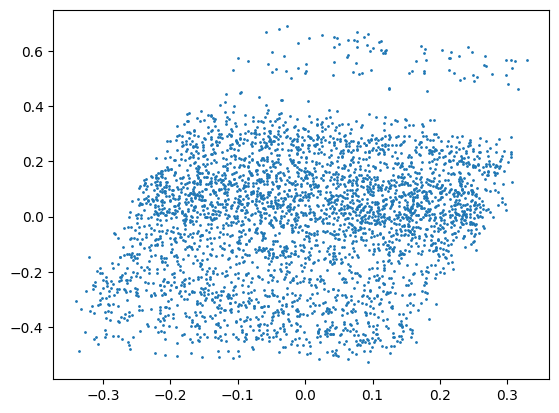

In [26]:
plt.scatter(mds_coords[:,0],mds_coords[:,1], s=1)
plt.show()

## 4- ToMATo

In [11]:
from gudhi.clustering.tomato import Tomato

### Influence of density 


 >>> Plot for DTM density


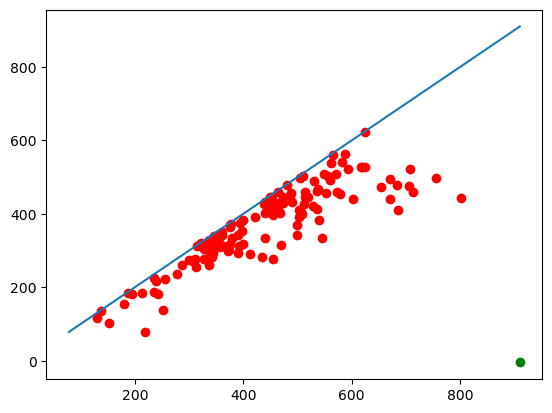


 >>> Plot for logDTM density


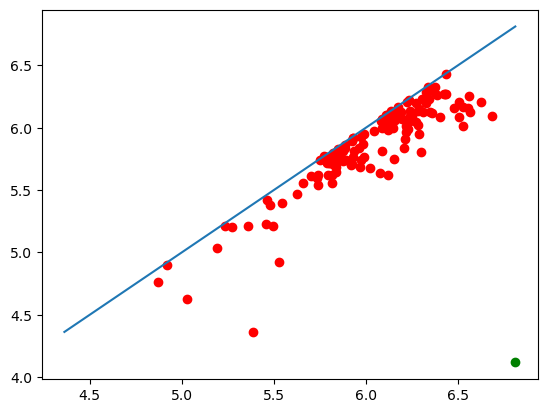

In [28]:
density_types = ['DTM', 'logDTM'] # We can't test KDE and logKDE density functions, because metric is "precomputed"
for density in density_types:
    t = Tomato(density_type=density, metric="precomputed", n_jobs=-1)
    t.fit(RMSD_m_sample)
    print(f"\n >>> Plot for {density} density")
    t.plot_diagram()